Creating FashionMNIST Images using Variational Autoencoder (VAE)

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Define transform
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# Download FashionMNIST Dataset 
training_data = datasets.FashionMNIST(
    root="data",
    download=True,
    transform=transform
)




100%|██████████| 26421880/26421880 [00:02<00:00, 11336555.82it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 190348.53it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3737564.24it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19845842.82it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [2]:
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
from torch.distributions.normal import Normal

def reparameterize(mu, log_var):
    # Compute the standard deviation from the log variance
    std = torch.exp(0.5 * log_var)
    # Generate random noise using the same shape as std
    eps = torch.randn_like(std)
    # Return the reparameterized sample
    return mu + eps * std

class VAE(nn.Module):
    def __init__(self):
      super().__init__()
      # Set the number of hidden units
      self.num_hidden=2
      self.conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1)
      self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
      self.conv3 = nn.Conv2d(64, 128, 3, stride=2,padding=1)

      self.flatten = nn.Flatten(start_dim = 1 )

      self.convT1 = nn.ConvTranspose2d(128, 64, 3, stride=2, output_padding=1, padding=1)
      self.convT2 = nn.ConvTranspose2d(64, 32, 3, stride=2, output_padding=1, padding=1)
      self.convT3 = nn.ConvTranspose2d(32, 1, 3, stride=2 , output_padding=1, padding=1)

      self.mu = nn.Linear(128 * 4 * 4 , self.num_hidden)
      self.log_var = nn.Linear(128 * 4 * 4 , self.num_hidden)

      self.shape_before_flattening = (128, 4, 4)
      self.fc = nn.Linear(self.num_hidden,np.prod(self.shape_before_flattening))
      self.reshape = lambda x: x.view(-1, *self.shape_before_flattening)

    def encoder(self,x):
      x = f.relu(self.conv1(x))
      x = f.relu(self.conv2(x))
      x = f.relu(self.conv3(x))
      x = self.flatten(x)
      z_mean = self.mu(x)
      z_logvar = self.log_var(x)

      return z_mean, z_logvar

    def decoder(self,z):

      x = self.fc(z)
      x = self.reshape(x)
      x = f.relu(self.convT1(x))
      x = f.relu(self.convT2(x))
      x = torch.sigmoid(self.convT3(x))
      return x

    def forward(self, x):
        # Pass the input through the encoder
        mu, log_var = self.encoder(x)

        # Reparameterize the latent variable
        z = reparameterize(mu, log_var)

        # Pass the latent variable through the decoder
        decoded = self.decoder(z)

        # Return the encoded output, decoded output, mean, and log variance
        return mu, log_var, decoded

    def sample(self, num_samples):
        with torch.no_grad():
            # Generate random noise
            z = torch.randn(num_samples, self.num_hidden)
            # Pass the noise through the decoder to generate samples
            samples = self.decoder(z)
        # Return the generated samples
        return samples


In [3]:

# Loss Function
def loss_function(recon_x, x, mu, logvar):

    # Compute the binary cross-entropy loss between the reconstructed output and the input data
    BCE = nn.BCELoss()
    BCE_LOSS = BCE(recon_x, x)


    # Compute the Kullback-Leibler divergence between the learned latent variable distribution and a standard Gaussian distribution
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Combine the two losses by adding them together and return the result
    return  BCE_LOSS + 0.001*KLD, BCE_LOSS, KLD


In [10]:
from google.colab import files

def train_vae(X_train, learning_rate=1e-3, num_epochs=20, batch_size=1):

    # Create the autoencoder model and optimizer
    model = VAE()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    random_sampler = torch.utils.data.RandomSampler(X_train, num_samples=10000)
    # Create a DataLoader to handle batching of the training data
    train_loader = torch.utils.data.DataLoader(
        X_train, batch_size=batch_size, sampler=random_sampler
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True)

    model.train()

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        best_val_loss = float('inf')
        
        for data, label in train_loader:

            # Forward pass
            mu, log_var, decoded = model(data)

            # Compute the loss and perform backpropagation
            loss, recons, latent = loss_function(decoded, data, mu, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the running loss
            total_loss += loss.item() * data.size(0)

        # Print the epoch loss
        epoch_loss = total_loss / len(train_loader.dataset)
        print(
            "Epoch {}/{}: loss={:.4f} recon_loss={:.4f} latent_loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss, recons, latent)
        )
        scheduler.step(epoch_loss)

        # save best vae model weights based on validation loss
        if epoch_loss < best_val_loss:
            best_val_loss = epoch_loss
            torch.save({"vae": model.state_dict()},'checkpoint.pth',)


    # download checkpoint file
    files.download('checkpoint.pth')
    # Return the trained model
    return model

In [11]:
# Train the model
trained_model = train_vae(training_data)


Epoch 1/20: loss=0.0622 recon_loss=0.3127 latent_loss=7.5877
Epoch 2/20: loss=0.0597 recon_loss=0.2781 latent_loss=7.7146
Epoch 3/20: loss=0.0590 recon_loss=0.3088 latent_loss=5.8631
Epoch 4/20: loss=0.0586 recon_loss=0.2044 latent_loss=5.4849
Epoch 5/20: loss=0.0584 recon_loss=0.4799 latent_loss=5.1622
Epoch 6/20: loss=0.0583 recon_loss=0.2804 latent_loss=5.8265
Epoch 7/20: loss=0.0580 recon_loss=0.4957 latent_loss=5.1930
Epoch 8/20: loss=0.0581 recon_loss=0.2479 latent_loss=6.4172
Epoch 9/20: loss=0.0579 recon_loss=0.3785 latent_loss=5.0182
Epoch 10/20: loss=0.0580 recon_loss=0.2009 latent_loss=7.2608
Epoch 11/20: loss=0.0577 recon_loss=0.5916 latent_loss=5.7310
Epoch 12/20: loss=0.0577 recon_loss=0.3840 latent_loss=7.0802
Epoch 13/20: loss=0.0582 recon_loss=0.4964 latent_loss=5.1849
Epoch 14/20: loss=0.0579 recon_loss=0.3417 latent_loss=5.7383
Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.
Epoch 15/20: loss=0.0570 recon_loss=0.3149 latent_loss=7.4262
Epoch 16/20: loss

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

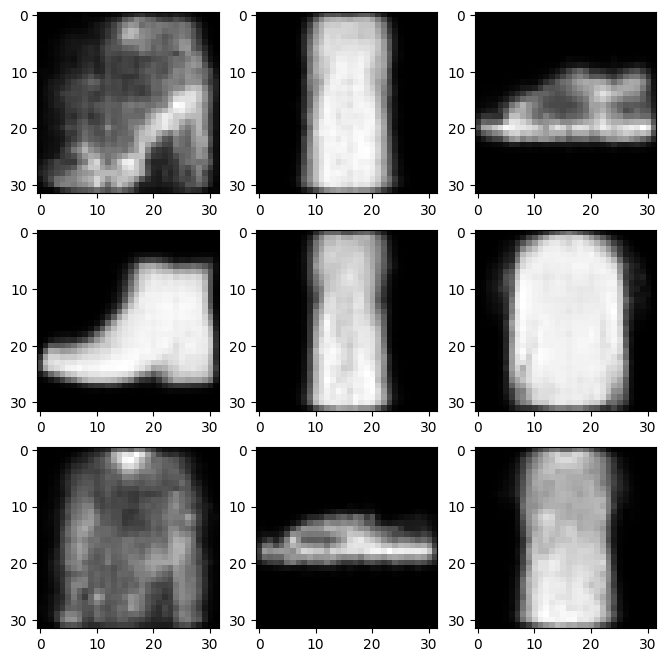

In [12]:
# Sampling from the learned model

inference_model = VAE()
state_dict = torch.load('checkpoint.pth')
inference_model.load_state_dict(state_dict['vae'])

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

for i in range(1, cols * rows + 1):
  img = inference_model.sample(1).detach().numpy()
  figure.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")

plt.show()